Assignment 5 \
Part 2: Car Evaluation Multi-class Classification \
Submitted by Group 5 \

Groupmembers:

1. Sajan Kumer Sarker (2111131642) (sajan.sarker@northsouth.edu)
2. Rafsan Jani Chowdhury (2011424642) (rafsan.chowdhury@northsouth.edu)
3. Rosely Mohammad (2014219642) (rosely.mohammad@northsouth.edu)

Algorithm: \
1. ZeroR classifier
2. OneR classifier
3. K-Nearest-Neighbor Classifiers
4. Naive Bayesian Classifier
5. Support vector machine (SVM)



**For Multi-class Classification problem report: Accuracy, Confusion matrix, Average Precision, Average Recall, Average F-score**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from collections import defaultdict

In [3]:
car_evaluation = pd.read_csv('/content/drive/MyDrive/CSE445-Assignment/dataset/car.data')

In [4]:
car_evaluation.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [5]:
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
car_evaluation.columns = column_names
car_evaluation.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [6]:
print('Number of missing values: ')
print(car_evaluation.isnull().sum())

Number of missing values: 
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


In [7]:
car_evaluation['buying'] = car_evaluation['buying'].map({'vhigh':3, 'high':2, 'med':1, 'low':0})
car_evaluation['maint'] = car_evaluation['maint'].map({'vhigh':3, 'high':2, 'med':1, 'low':0})
car_evaluation['doors'] = car_evaluation['doors'].map({'2':0, '3':1, '4':2, '5more':3})
car_evaluation['persons'] = car_evaluation['persons'].map({'2':0, '4':1, 'more':2})
car_evaluation['lug_boot'] = car_evaluation['lug_boot'].map({'small':0, 'med':1, 'big': 2})
car_evaluation['safety'] = car_evaluation['safety'].map({'low':0, 'med':1, 'high': 2})

car_evaluation['class'] = car_evaluation['class'].map({'unacc':0, 'acc':1, 'good': 2, 'vgood':3})

In [8]:
car_evaluation.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,0,1,0
1,3,3,0,0,0,2,0
2,3,3,0,0,1,0,0
3,3,3,0,0,1,1,0
4,3,3,0,0,1,2,0


In [9]:
X = car_evaluation.drop(columns='class')
y = car_evaluation['class']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# this will used after cross-validation
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

print(f'Train Data Shape (X, y): {X_train.shape, y_train.shape}')
print(f'Validation Data Shape (X, y): {X_val.shape, y_val.shape}')
print(f'Test Data Shape (X, y): {X_test.shape, y_test.shape}')

Train Data Shape (X, y): ((1208, 6), (1208,))
Validation Data Shape (X, y): ((259, 6), (259,))
Test Data Shape (X, y): ((260, 6), (260,))


In [10]:
# functions to calculate: accuracy, average precision, average recall, average f-score.

# Accuracy
def accuracy_score(y_actual, y_predict):
  correct = 0
  total_samples = len(y_actual)

  for predict, actual in zip(y_predict, y_actual):
    if predict == actual:
      correct += 1

  return (correct/ total_samples)

# Precision
def precision_score(y_actual, y_predict):
  precision_scores = []

  for class_label in set(y_actual):
    true_positive = 0
    false_positive = 0

    for actual, predict in zip(y_actual, y_predict):
      if predict == class_label:
        if actual == class_label:
          true_positive += 1
        else:
          false_positive += 1

    if true_positive+false_positive ==0:
      class_precision = 0.0
    else:
      class_precision = true_positive / (true_positive + false_positive)
    precision_scores.append(class_precision)
  return precision_scores

# average precision
def average_precision_score_macro(precision_score, y_actual):
  return sum(precision_score)/len(set(y_actual))

# recall
def recall_score(y_actual, y_predict):
  recall_scores = []

  for class_label in set(y_actual):
    true_positive = 0
    false_negative = 0

    for actual, predict in zip(y_actual, y_predict):
      if actual == class_label:
        if predict == class_label:
          true_positive += 1
        else:
          false_negative += 1

    if true_positive+false_negative ==0:
      class_recall = 0.0
    else:
      class_recall = true_positive / (true_positive + false_negative)

    recall_scores.append(class_recall)
  return recall_scores

# average recall
def average_recall_score_macro(recall_score, y_actual):
  return sum(recall_score)/len(set(y_actual))

# f-score
def fscore(y_actual,y_predict):
  f_score_total = []

  for class_label in set(y_actual):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for actual, predict in zip(y_actual, y_predict):
      if predict == class_label:
        if actual == class_label:
          true_positive += 1
        else:
          false_positive += 1
      elif actual == class_label:
        false_negative += 1

    if true_positive + false_positive == 0:
      precision = 0.0
    else:
      precision = true_positive/(true_positive+false_positive)

    if true_positive + false_negative == 0:
      precision = 0.0
    else:
      recall = true_positive/(true_positive+false_negative)

    if precision + recall ==0:
      f_score = 0.0
    else:
      f_score = 2*true_positive/((2*true_positive)+false_positive+false_negative)

    f_score_total.append(f_score)
  return f_score_total

# fscore average
def fscore_average_macro(fscore, y_actual):
  return sum(fscore)/len(set(y_actual))

# display confusion matrix
def display_confusion_matrix(y_test, y_predict):
  num_class = len(set(y_test))
  class_labels = list(set(y_test))

  plt.figure(figsize=(8, 6))

  conf_matrix = np.zeros((num_class, num_class), dtype=int)
  for actual, predict in zip(y_test, y_predict):
      conf_matrix[actual, predict] += 1

  plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
  plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
  plt.xlabel("Predicted Labels", fontsize=12)
  plt.ylabel("True Labels", fontsize=12)

  for i in range(num_class):
      for j in range(num_class):
          plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='red', fontsize=12)

  plt.xticks(ticks=range(num_class), labels=class_labels, fontsize=10)
  plt.yticks(ticks=range(num_class), labels=class_labels, fontsize=10)
  plt.tight_layout()
  plt.show()


*****
# ZeroR Classifier

Majority Class: 0
ZeroR Baseline Accuracy: 70.01%


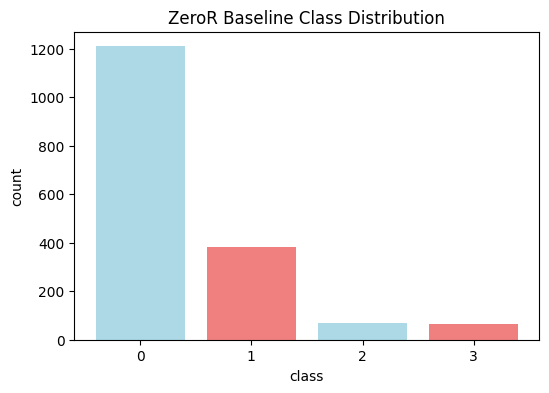

In [11]:
class_counts = y.value_counts()
majority_class = class_counts.idxmax()
majority_count = class_counts.max()

baseline_accuracy = majority_count/len(y) * 100   # calculate baseline accuracy

print(f"Majority Class: {majority_class}")
print(f"ZeroR Baseline Accuracy: {baseline_accuracy:.2f}%")

# plot data
plt.figure(figsize=(6, 4))
plt.title(f'ZeroR Baseline Class Distribution')
plt.bar(class_counts.index, class_counts.values, color=['lightblue', 'lightcoral'])
plt.xticks([0,1,2,3],['0','1','2','3'])
plt.xlabel('class')
plt.ylabel('count')
plt.show()

*****
# OneR Classifier

In [12]:
# OneR Classifier implementation
class OneRClassifier:
  def __init__(self):
    self.rule = None

  def fit(self, X, y):
    best_rule = None
    best_error = float('inf')

    for column in X.columns:
      freq_table = defaultdict(lambda: defaultdict(int))
      for value, label in zip(X[column], y):
        freq_table[value][label] += 1

      error_rate = sum(max(freq_table[value].values()) for value in freq_table)/len(y)

      if error_rate < best_error:
        best_rule = (column, freq_table)
        best_error = error_rate
    self.rule = best_rule

  def predict(self, X):
    if self.rule is None:
      raise Exception("Classifier has not been trained yet!")
    column, freq_table = self.rule

    predict = []
    for value in X[column]:
      predict.append(max(freq_table[value], key=freq_table[value].get))
    return predict

In [13]:
#oneR classifier initialize
oner = OneRClassifier()
oner.fit(X_train, y_train)

y_val_predict = oner.predict(X_val)
print("OneR validation set Accuracy:", accuracy_score(y_val, y_val_predict))

y_test_predict = oner.predict(X_test)
print("OneR test set Accuracy:", accuracy_score(y_test, y_test_predict))

OneR validation set Accuracy: 0.6872586872586872
OneR test set Accuracy: 0.7038461538461539


*****
# KNN, Naive Bayesian, SVM Classifiers Base Model

In [14]:
# Base model train and accuracy on validation dataset
knn_base = KNeighborsClassifier()
svc_base = SVC()
nb_base = GaussianNB()

knn_base.fit(X_train, y_train)
svc_base.fit(X_train, y_train)
nb_base.fit(X_train, y_train)

knn_pred_val = knn_base.predict(X_val)
svc_pred_val = svc_base.predict(X_val)
nb_pred_val = nb_base.predict(X_val)

print("KNN Accuracy:", accuracy_score(y_val, knn_pred_val))
print("SVM Accuracy:", accuracy_score(y_val, svc_pred_val))
print("Naive Bayes Accuracy:", accuracy_score(y_val, nb_pred_val))

KNN Accuracy: 0.9343629343629344
SVM Accuracy: 0.9536679536679536
Naive Bayes Accuracy: 0.640926640926641


*****
#K-Nearest-Neighbor Classifiers CV

In [15]:
# initialize the classifier models
knn_classifier = KNeighborsClassifier(n_neighbors=5)

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(estimator=knn_classifier, param_grid=knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

knn_best_params = knn_grid.best_params_
print("Best KNN Parameters:", knn_best_params)

Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


In [16]:
knn_final_model = KNeighborsClassifier(**knn_best_params)
knn_final_model.fit(X_train, y_train)

knn_pred_val = knn_final_model.predict(X_val)
print("KNN Accuracy:", accuracy_score(y_val, knn_pred_val))

KNN Accuracy: 0.9382239382239382


KNN: 
Accuracy: 0.9307692307692308
Average Precision: 0.8722098628105301
Average Recall: 0.735813366960908
Aveerage F1-Score: 0.7772344756940393


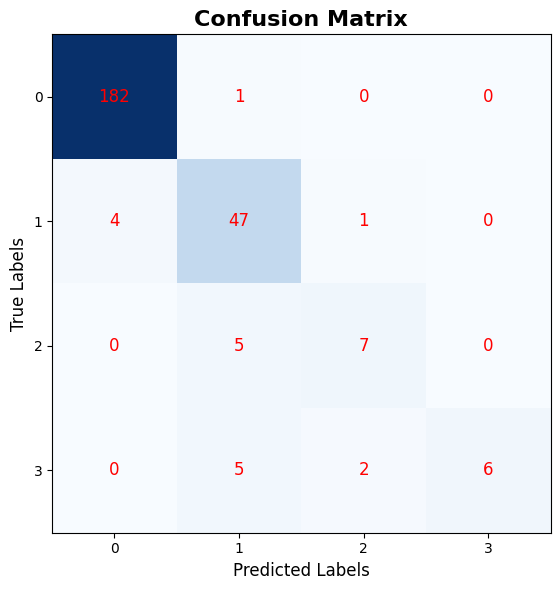

In [26]:
# retrain knn final model using train_val set and evaluate on test set
knn_final_model.fit(X_train_val, y_train_val)

y_test_pred_knn = knn_final_model.predict(X_test)

print("KNN: ")
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_knn)}')
precision = precision_score(y_test, y_test_pred_knn)
print(f'Average Precision: {average_precision_score_macro(precision, y_test)}')
recall = recall_score(y_test, y_test_pred_knn)
print(f'Average Recall: {average_recall_score_macro(recall, y_test)}')
f_score = fscore(y_test, y_test_pred_knn)
print(f'Aveerage F1-Score: {fscore_average_macro(f_score, y_test)}')

display_confusion_matrix(y_test, y_test_pred_knn)

*****
#Naive Bayesian Classifiers CV

In [18]:
# initialize the classifier models
nb_classifier = GaussianNB()

nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_grid = GridSearchCV(estimator=nb_classifier, param_grid=nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

nb_grid.fit(X_train, y_train)

nb_best_params = nb_grid.best_params_
print("Best KNN Parameters:", nb_best_params)

Best KNN Parameters: {'var_smoothing': 1e-05}


In [19]:
nb_final_model = GaussianNB(**nb_best_params)
nb_final_model.fit(X_train, y_train)

nb_pred_val = nb_final_model.predict(X_val)
print("Naive Bayesian Accuracy:", accuracy_score(y_val, nb_pred_val))

Naive Bayesian Accuracy: 0.7335907335907336


Naive Bayesian: 
Accuracy: 0.8038461538461539
Average Precision: 0.6531159316873603
Average Recall: 0.6415510718789408
Aveerage F1-Score: 0.5808859649259409



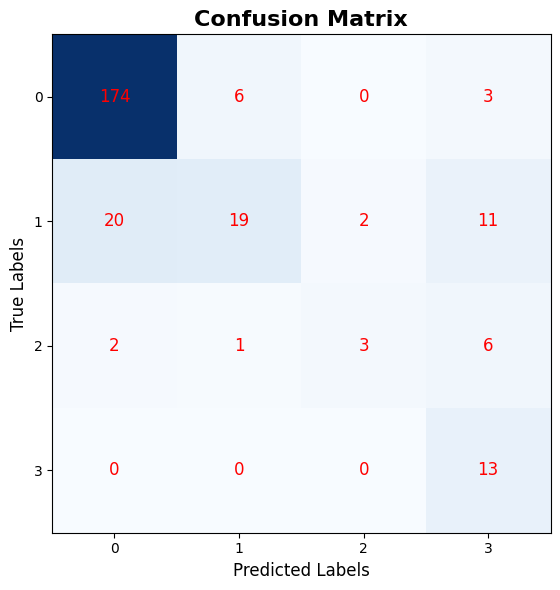

In [25]:
# retrain naive bayesian final model using train_val set and evaluate on test set
nb_final_model.fit(X_train_val, y_train_val)

y_test_pred_nb = nb_final_model.predict(X_test)

print("Naive Bayesian: ")
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_nb)}')
precision = precision_score(y_test, y_test_pred_nb)
print(f'Average Precision: {average_precision_score_macro(precision, y_test)}')
recall = recall_score(y_test, y_test_pred_nb)
print(f'Average Recall: {average_recall_score_macro(recall, y_test)}')
f_score = fscore(y_test, y_test_pred_nb)
print(f'Aveerage F1-Score: {fscore_average_macro(f_score, y_test)}')

print()

display_confusion_matrix(y_test, y_test_pred_nb)

*****
# SVM Classifiers CV

In [21]:
# initialize the classifier models
svm_classifier = SVC()

svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(estimator=svm_classifier, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

svm_best_params = svm_grid.best_params_
print("Best SVM Parameters:", svm_best_params)

Best SVM Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [22]:
svm_final_model = SVC(**svm_best_params)
svm_final_model.fit(X_train, y_train)

svm_pred_val = svm_final_model.predict(X_val)
print("Naive Bayesian Accuracy:", accuracy_score(y_val, svm_pred_val))

Naive Bayesian Accuracy: 0.9768339768339769


SVM: 
Accuracy: 0.9923076923076923
Average Precision: 0.9642857142857143
Average Recall: 0.9615384615384616
Aveerage F1-Score: 0.9599358974358975



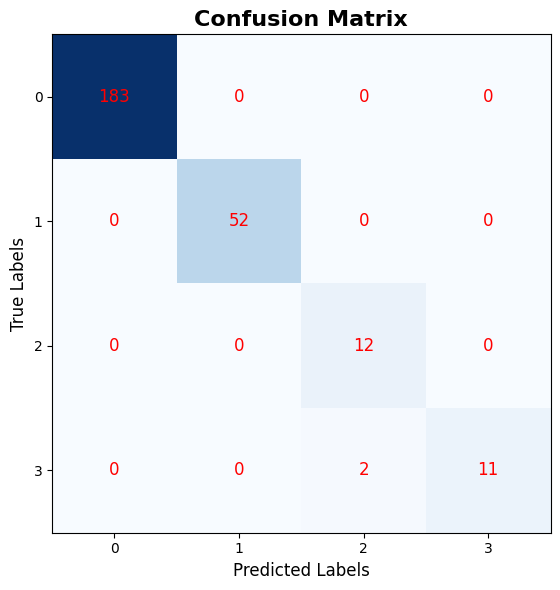

In [27]:
# retrain svm final model using train_val set and evaluate on test set
svm_final_model.fit(X_train_val, y_train_val)

y_test_pred_svm = svm_final_model.predict(X_test)

print("SVM: ")
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_svm)}')
precision = precision_score(y_test, y_test_pred_svm)
print(f'Average Precision: {average_precision_score_macro(precision, y_test)}')
recall = recall_score(y_test, y_test_pred_svm)
print(f'Average Recall: {average_recall_score_macro(recall, y_test)}')
f_score = fscore(y_test, y_test_pred_svm)
print(f'Aveerage F1-Score: {fscore_average_macro(f_score, y_test)}')

print()

display_confusion_matrix(y_test, y_test_pred_svm)